In [1]:
import os
os.chdir('../..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import random

import scipy.stats as st

import seaborn as sns
sns.set_style("whitegrid")

from modules.MMD import mmd_loss

from tgan.model import TGANModel

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Variables

In [3]:
files = ['../data/Chicago/full.csv', '../synth_data/DATGAN_NOLINKS_1000.csv', '../synth_data/DATGAN_FC_1000.csv']

In [4]:
colors = ['black', 'orange', 'tab:blue']
labels = ['original', 'datgan_nolinks', 'datgan_fc']

In [5]:
dfs = [pd.read_csv(file) for file in files]

## Transform all columns in numerical values

In [6]:
ints = ['travel_dow', 'hh_vehicles', 'hh_size', 'hh_bikes', 'hh_descr', 'hh_income', 'gender', 'education_level', 'age']
floats = ['departure_time', 'distance', 'license']

In [7]:
dct = {}

for i in ints:
    dct[i] = 'int64'
    
for i in floats:
    dct[i] = 'float64'

In [8]:
dct

{'travel_dow': 'int64',
 'hh_vehicles': 'int64',
 'hh_size': 'int64',
 'hh_bikes': 'int64',
 'hh_descr': 'int64',
 'hh_income': 'int64',
 'gender': 'int64',
 'education_level': 'int64',
 'age': 'int64',
 'departure_time': 'float64',
 'distance': 'float64',
 'license': 'float64'}

In [9]:
dfs = [df.astype(dct) for df in dfs]

In [10]:
choices = {}
trip_purpose = {}
work_status = {}

for c in ['choice', 'trip_purpose', 'work_status']: 
    dct = {}
    
    for n, i in enumerate(dfs[0][c].unique()):
        if c == 'choice':
            choices[n] = i
            
        if c == 'trip_purpose':
            trip_purpose[n] = i
            
        if c == 'work_status':
            work_status[n] = i
        
        dct[i] = n
        
    dfs = [df.replace(dct) for df in dfs]

In [11]:
dfs[0].dtypes

choice               int64
travel_dow           int64
trip_purpose         int64
distance           float64
hh_vehicles          int64
hh_size              int64
hh_bikes             int64
hh_descr             int64
hh_income            int64
gender               int64
age                  int64
license            float64
education_level      int64
work_status          int64
departure_time     float64
dtype: object

# Test the distributions

In [12]:
dfs[0].columns

Index(['choice', 'travel_dow', 'trip_purpose', 'distance', 'hh_vehicles',
       'hh_size', 'hh_bikes', 'hh_descr', 'hh_income', 'gender', 'age',
       'license', 'education_level', 'work_status', 'departure_time'],
      dtype='object')

In [13]:
cont_cols = [3, 10, 14]

In [14]:
msk = []

for i in range(len(dfs[0].columns)):
    msk.append(i not in cont_cols)

In [15]:
dfs[0].columns[msk]

Index(['choice', 'travel_dow', 'trip_purpose', 'hh_vehicles', 'hh_size',
       'hh_bikes', 'hh_descr', 'hh_income', 'gender', 'license',
       'education_level', 'work_status'],
      dtype='object')

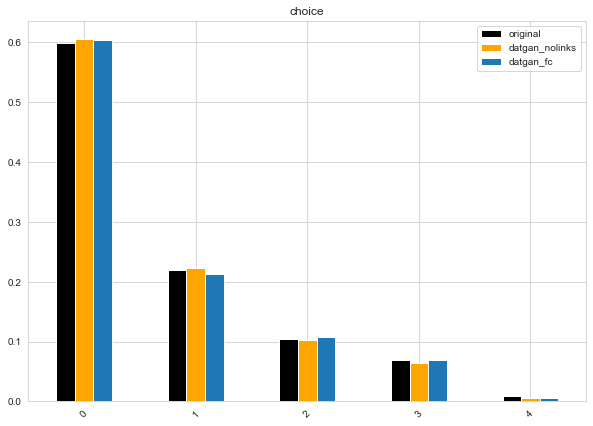

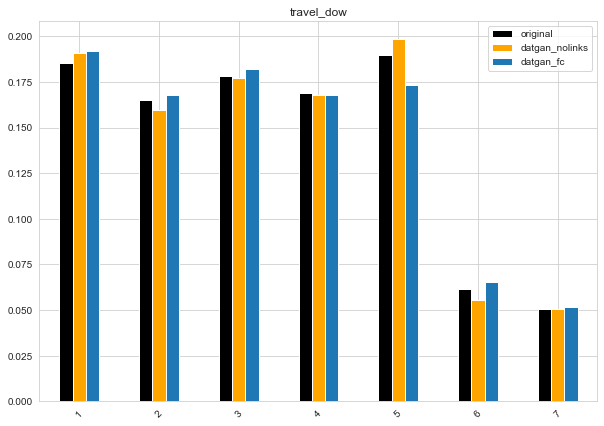

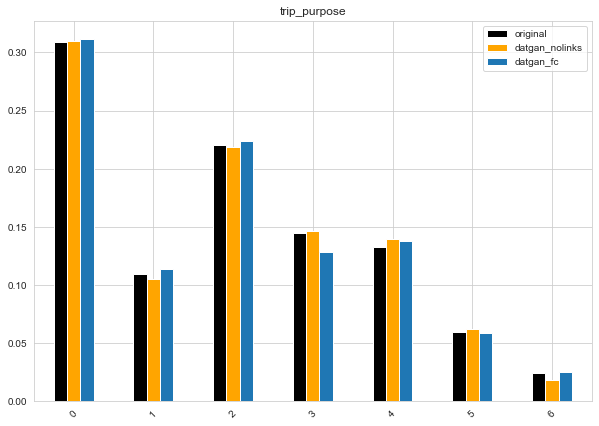

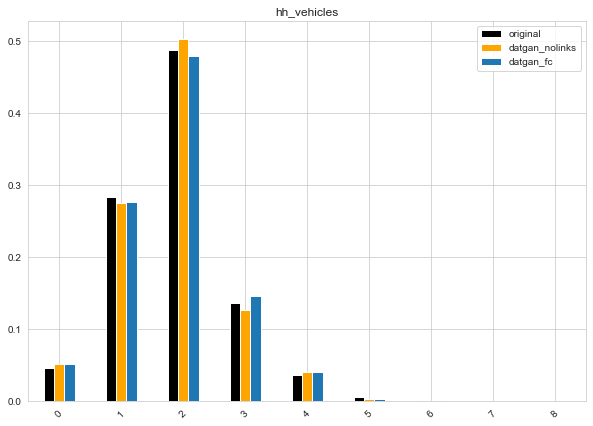

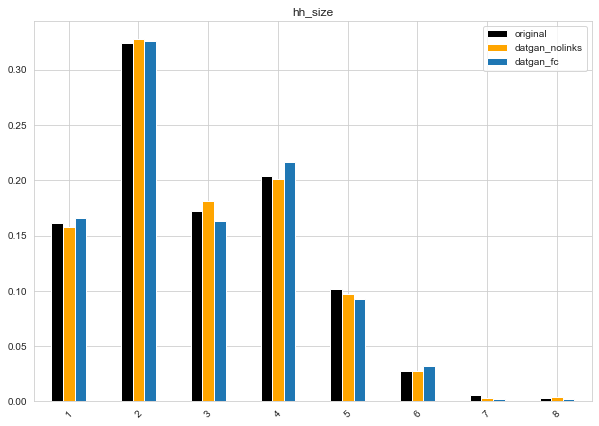

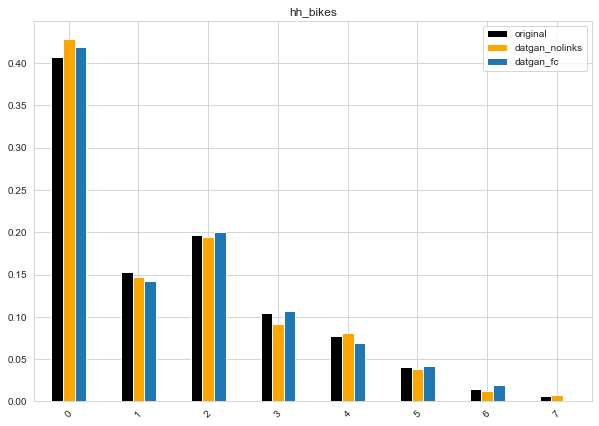

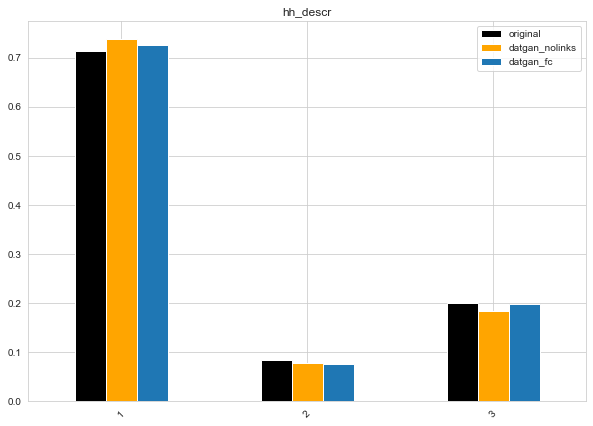

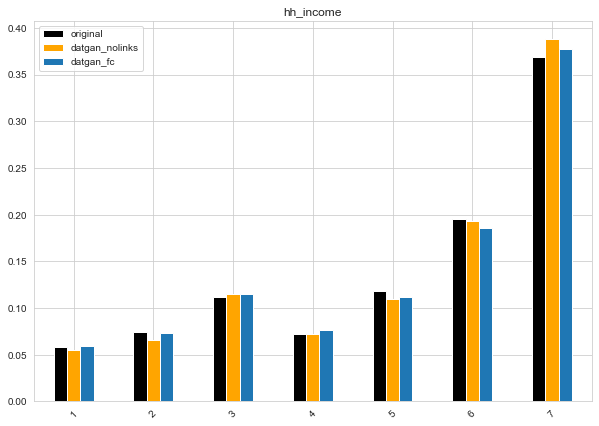

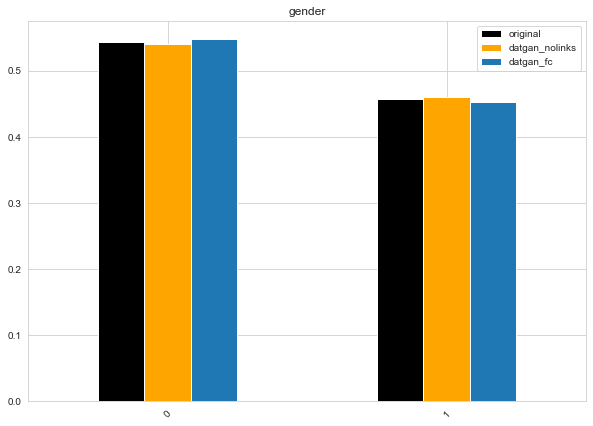

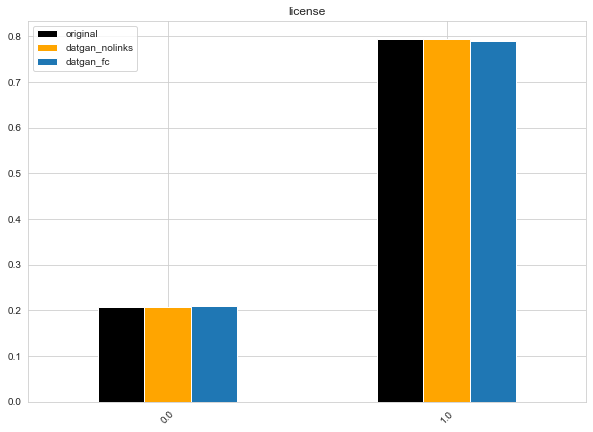

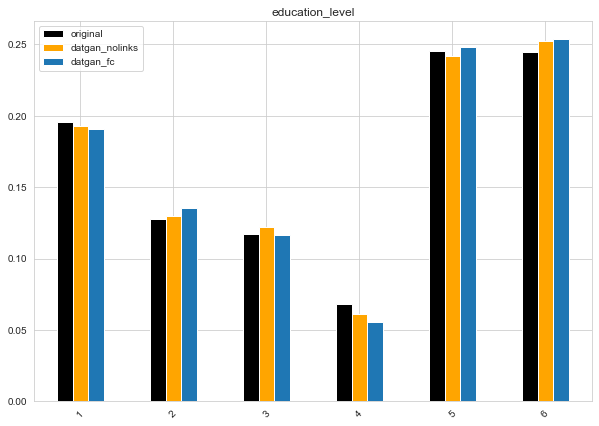

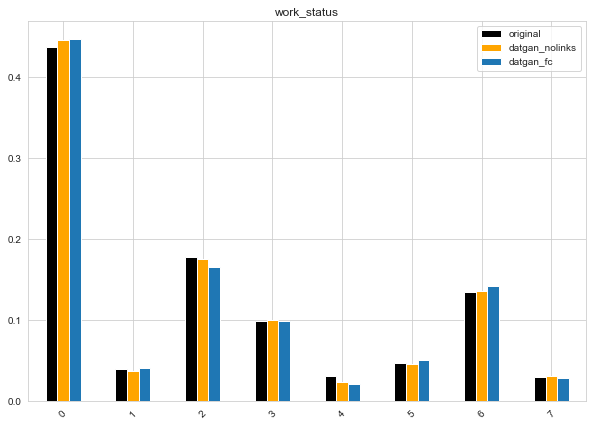

In [16]:
for col in dfs[0].columns[msk]:
    
    probs = [df[col].value_counts(normalize=True) for df in dfs]
    
    dct = {}
    for l in labels:
        dct[l] = []
    
    idx = np.sort(probs[0].index)
    
    for i in idx:
        
        for j, l in enumerate(labels):      
            try:
                dct[l].append(probs[j].loc[i])
            except:
                dct[l].append(0)

        
    tmp_df = pd.DataFrame(dct, index=idx)
    
    tmp_df.plot(figsize=(10,7), kind='bar', color=colors)

    plt.legend()
    
    plt.xticks(rotation=45)
    plt.title(col)

    plt.savefig('../figures/tgan-chicago/distributions/' + col + '.pdf', bbox_inches='tight')
    plt.savefig('../figures/tgan-chicago/distributions/' + col + '.png', bbox_inches='tight')

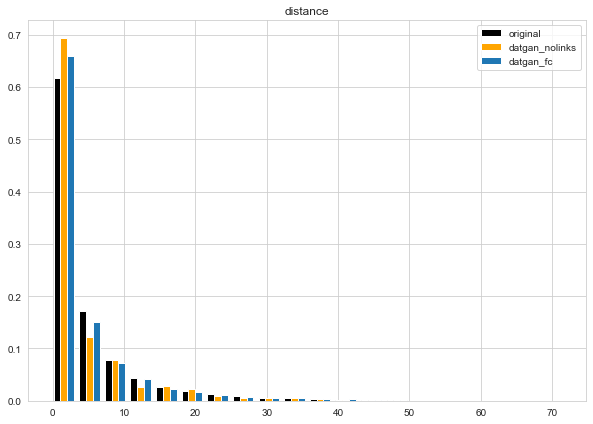

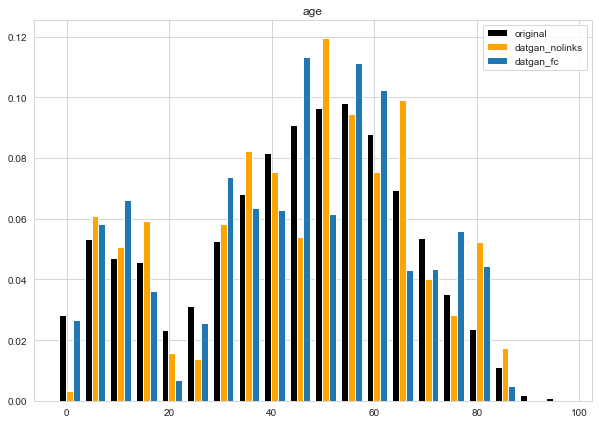

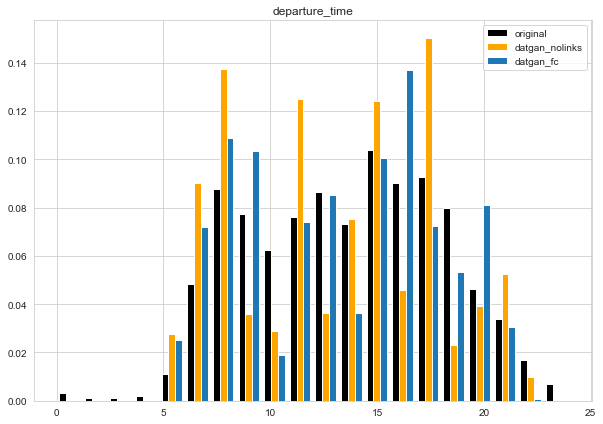

In [17]:
for col in dfs[0].columns[~np.array(msk)]:
    
    vals = [df[col] for df in dfs]
    weights = [np.ones_like(v)/len(v) for v in vals]
    
    plt.figure(figsize=(10,7))
    
    bins=np.histogram(np.hstack((vals[0],vals[1])), bins=20)[1] 
    
    plt.hist(vals,
             bins=bins, weights = weights,
             label=labels, color=colors)
    
    plt.legend()
    plt.title(col)
    
    plt.savefig('../figures/tgan-chicago/distributions/' + col + '.pdf', bbox_inches='tight')
    plt.savefig('../figures/tgan-chicago/distributions/' + col + '.png', bbox_inches='tight')


# Sub distribution

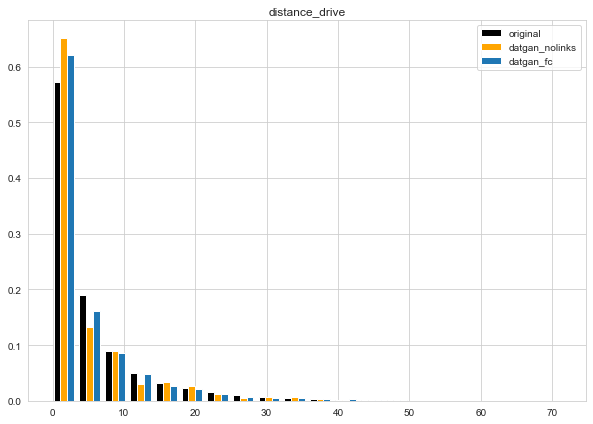

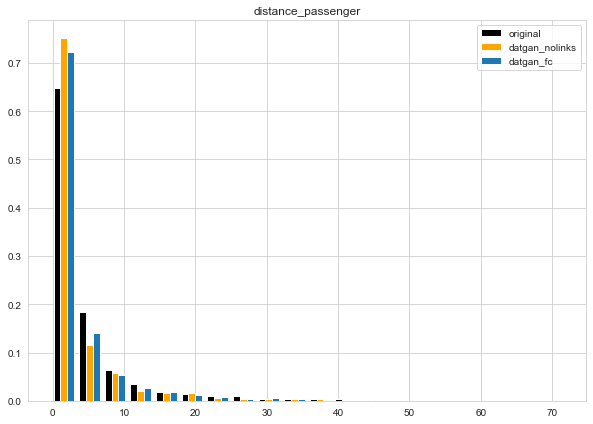

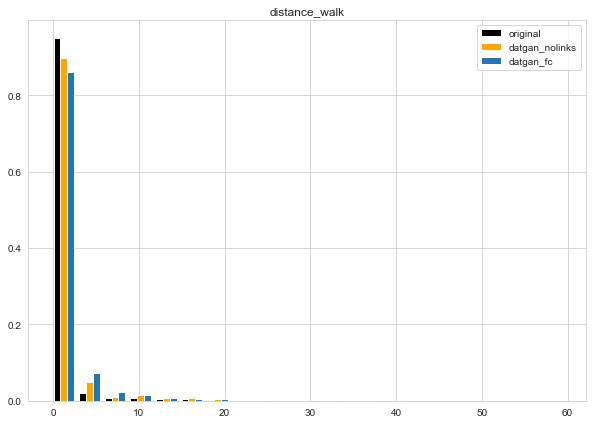

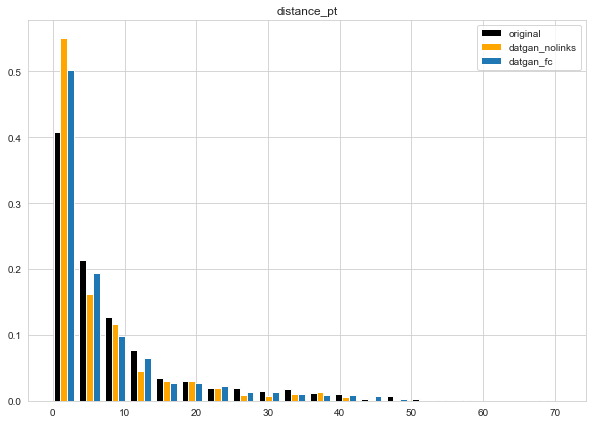

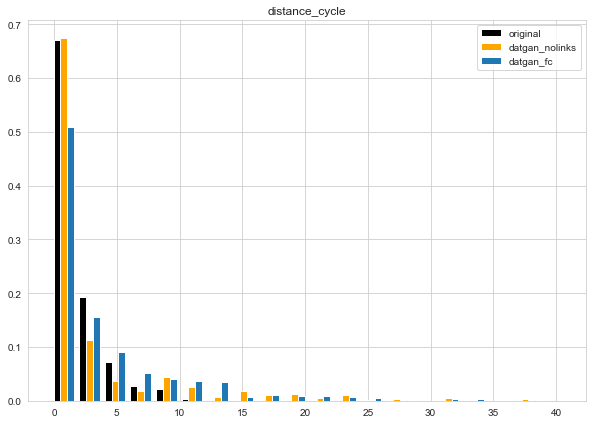

In [18]:
for i in dfs[0].choice.unique():
    
    vals = [df[df.choice == i].distance for df in dfs]
    weights = [np.ones_like(v)/len(v) for v in vals]

    plt.figure(figsize=(10,7))

    bins=np.histogram(np.hstack((vals[0],vals[1])), bins=20)[1] 
    
    plt.hist(vals,
             bins=bins, weights = weights,
             label=labels, color=colors)
    
    plt.legend()
    
    plt.title('distance_' + choices[i])
    
    plt.savefig('../figures/tgan-chicago/sub/distance_' + choices[i] + '.pdf', bbox_inches='tight')
    plt.savefig('../figures/tgan-chicago/sub/distance_' + choices[i] + '.png', bbox_inches='tight')


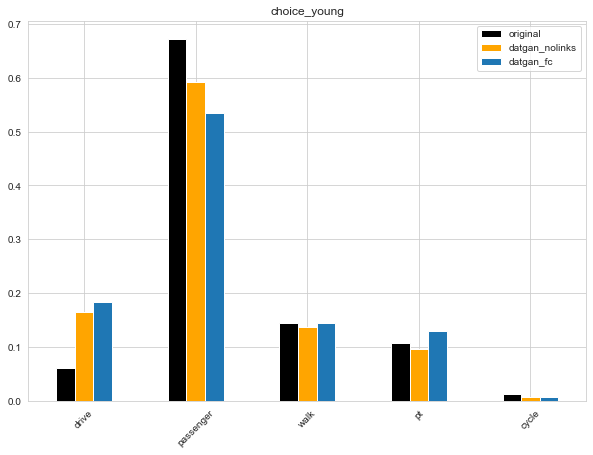

In [19]:
vals = [df[df.age <= 18].choice for df in dfs]

probs = [v.value_counts(normalize=True) for v in vals]

dct = {}
for l in labels:
    dct[l] = []

idx = np.sort(probs[0].index)

for i in idx:

    for j, l in enumerate(labels):      
        try:
            dct[l].append(probs[j].loc[i])
        except:
            dct[l].append(0)


tmp_df = pd.DataFrame(dct, index=idx)

tmp_df.plot(figsize=(10,7), kind='bar', color=colors)

plt.legend()

plt.xticks(list(range(len(choices))), list(choices.values()), rotation=45)

plt.title('choice_young')

plt.savefig('../figures/tgan-chicago/sub/choice_young.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/choice_young.png', bbox_inches='tight')


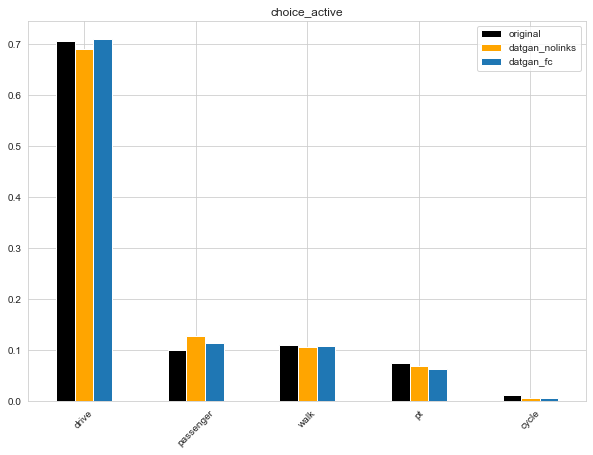

In [20]:
vals = [df[(df.age > 18) & (df.age <= 50)].choice for df in dfs]
probs = [v.value_counts(normalize=True) for v in vals]

dct = {}
for l in labels:
    dct[l] = []

idx = np.sort(probs[0].index)

for i in idx:

    for j, l in enumerate(labels):      
        try:
            dct[l].append(probs[j].loc[i])
        except:
            dct[l].append(0)


tmp_df = pd.DataFrame(dct, index=idx)

tmp_df.plot(figsize=(10,7), kind='bar', color=colors)

plt.legend()

plt.xticks(list(range(len(choices))), list(choices.values()), rotation=45)

plt.title('choice_active')

plt.savefig('../figures/tgan-chicago/sub/choice_active.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/choice_active.png', bbox_inches='tight')


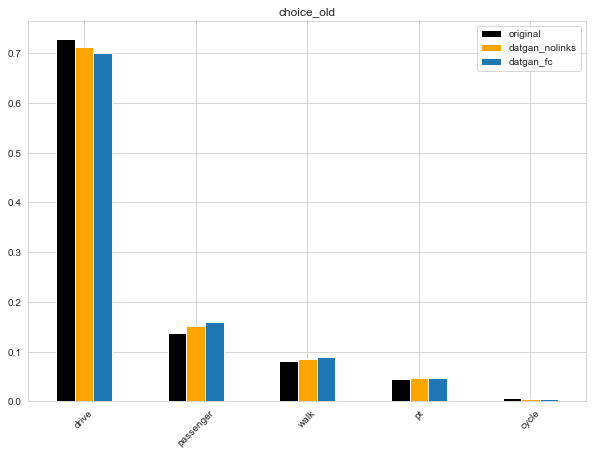

In [21]:
vals = [df[(df.age > 50)].choice for df in dfs]
probs = [v.value_counts(normalize=True) for v in vals]

dct = {}
for l in labels:
    dct[l] = []

idx = np.sort(probs[0].index)

for i in idx:

    for j, l in enumerate(labels):      
        try:
            dct[l].append(probs[j].loc[i])
        except:
            dct[l].append(0)


tmp_df = pd.DataFrame(dct, index=idx)

tmp_df.plot(figsize=(10,7), kind='bar', color=colors)

plt.legend()

plt.xticks(list(range(len(choices))), list(choices.values()), rotation=45)

plt.title('choice_old')

plt.savefig('../figures/tgan-chicago/sub/choice_old.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/choice_old.png', bbox_inches='tight')


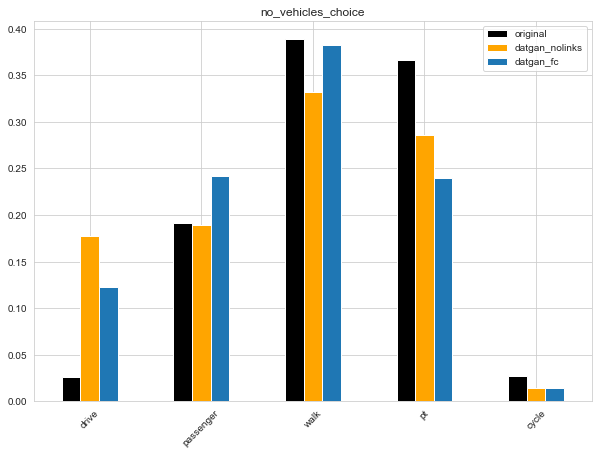

In [22]:
vals = [df[df.hh_vehicles == 0].choice for df in dfs]
probs = [v.value_counts(normalize=True) for v in vals]

dct = {}
for l in labels:
    dct[l] = []

idx = np.sort(probs[0].index)

for i in idx:

    for j, l in enumerate(labels):      
        try:
            dct[l].append(probs[j].loc[i])
        except:
            dct[l].append(0)


tmp_df = pd.DataFrame(dct, index=idx)

tmp_df.plot(figsize=(10,7), kind='bar', color=colors)

plt.legend()

plt.xticks(list(range(len(choices))), list(choices.values()), rotation=45)

plt.title('no_vehicles_choice')

plt.savefig('../figures/tgan-chicago/sub/no_vehicles_choice.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/no_vehicles_choice.png', bbox_inches='tight')

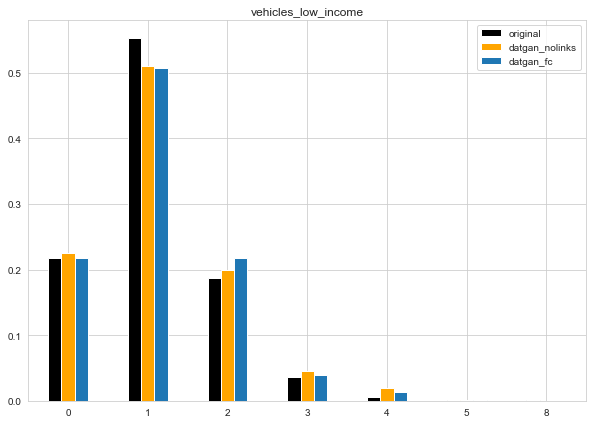

In [23]:
vals = [df[df.hh_income <= 2].hh_vehicles for df in dfs]
probs = [v.value_counts(normalize=True) for v in vals]

dct = {}
for l in labels:
    dct[l] = []

idx = np.sort(probs[0].index)

for i in idx:

    for j, l in enumerate(labels):      
        try:
            dct[l].append(probs[j].loc[i])
        except:
            dct[l].append(0)


tmp_df = pd.DataFrame(dct, index=idx)

tmp_df.plot(figsize=(10,7), kind='bar', color=colors)

plt.xticks(rotation=0)

plt.legend()

plt.title('vehicles_low_income')

plt.savefig('../figures/tgan-chicago/sub/vehicles_low_income.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/vehicles_low_income.png', bbox_inches='tight')

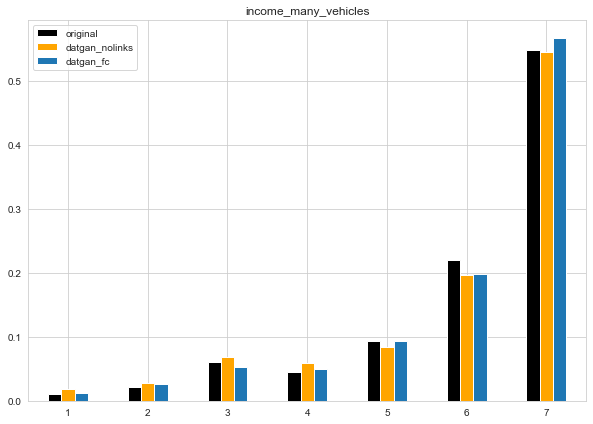

In [24]:
vals = [df[df.hh_vehicles > 2].hh_income for df in dfs]
probs = [v.value_counts(normalize=True) for v in vals]

dct = {}
for l in labels:
    dct[l] = []

idx = np.sort(probs[0].index)

for i in idx:

    for j, l in enumerate(labels):      
        try:
            dct[l].append(probs[j].loc[i])
        except:
            dct[l].append(0)


tmp_df = pd.DataFrame(dct, index=idx)

tmp_df.plot(figsize=(10,7), kind='bar', color=colors)

plt.xticks(rotation=0)

plt.legend()

plt.title('income_many_vehicles')

plt.savefig('../figures/tgan-chicago/sub/income_many_vehicles.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/income_many_vehicles.png', bbox_inches='tight')

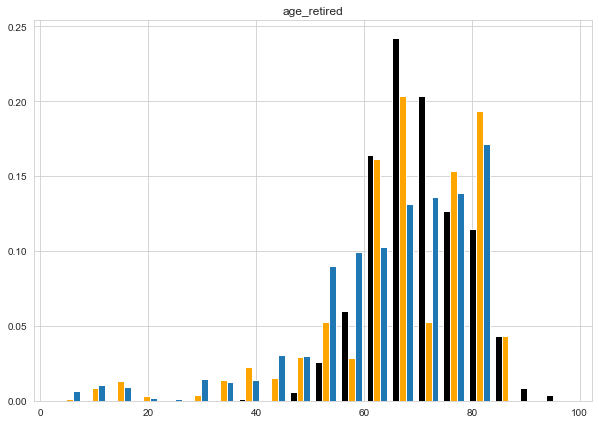

In [25]:
vals = [df[df.work_status == 6].age for df in dfs]
weights = [np.ones_like(v)/len(v) for v in vals]

plt.figure(figsize=(10,7))

bins=np.histogram(np.hstack((vals[0],vals[1])), bins=20)[1] 

plt.hist(vals,
         bins=bins, weights = weights,
         label=labels, color=colors)

plt.title('age_retired')

plt.savefig('../figures/tgan-chicago/sub/age_retired.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/age_retired.png', bbox_inches='tight')

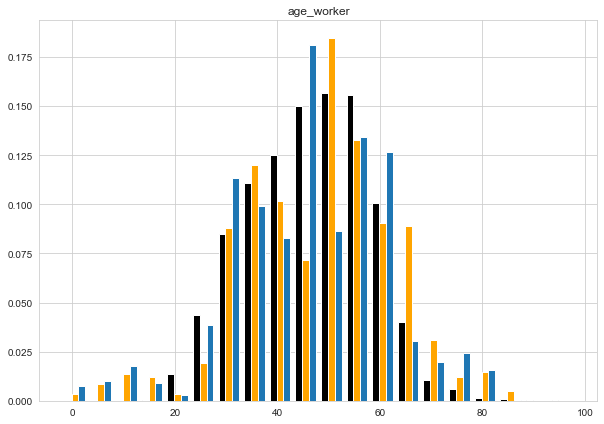

In [26]:
vals = [df[df.work_status == 0].age for df in dfs]
weights = [np.ones_like(v)/len(v) for v in vals]

plt.figure(figsize=(10,7))

bins=np.histogram(np.hstack((vals[0],vals[1])), bins=20)[1] 

plt.hist(vals,
         bins=bins, weights = weights,
         label=labels, color=colors)

plt.title('age_worker')

plt.savefig('../figures/tgan-chicago/sub/age_worker.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/age_worker.png', bbox_inches='tight')

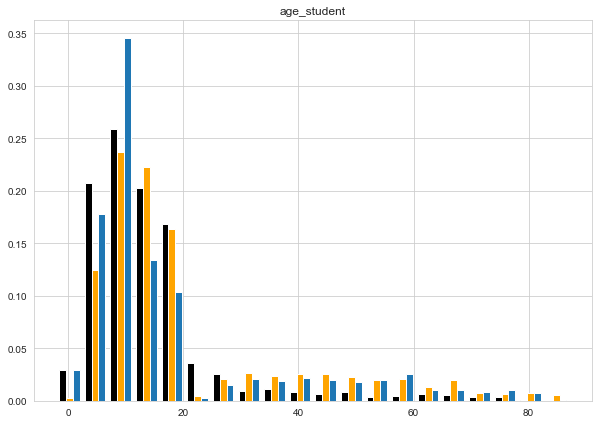

In [27]:
vals = [df[df.work_status == 2].age for df in dfs]
weights = [np.ones_like(v)/len(v) for v in vals]

plt.figure(figsize=(10,7))

bins=np.histogram(np.hstack((vals[0],vals[1])), bins=20)[1] 

plt.hist(vals,
         bins=bins, weights = weights,
         label=labels, color=colors)

plt.title('age_student')

plt.savefig('../figures/tgan-chicago/sub/age_student.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/age_student.png', bbox_inches='tight')

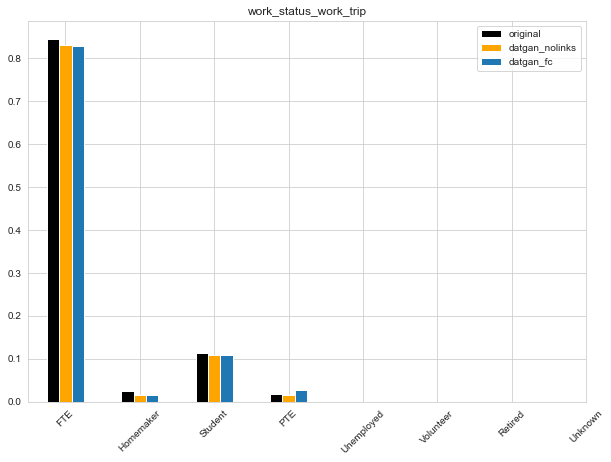

In [28]:
vals = [df[df.trip_purpose == 4].work_status for df in dfs]
probs = [v.value_counts(normalize=True) for v in vals]

dct = {}
for l in labels:
    dct[l] = []

idx = np.sort(probs[0].index)

for i in idx:

    for j, l in enumerate(labels):      
        try:
            dct[l].append(probs[j].loc[i])
        except:
            dct[l].append(0)


tmp_df = pd.DataFrame(dct, index=idx)

tmp_df.plot(figsize=(10,7), kind='bar', color=colors)

plt.legend()

plt.xticks(list(range(len(work_status))), list(work_status.values()), rotation=45)

plt.title('work_status_work_trip')

plt.savefig('../figures/tgan-chicago/sub/work_status_work_trip.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/work_status_work_trip.png', bbox_inches='tight')

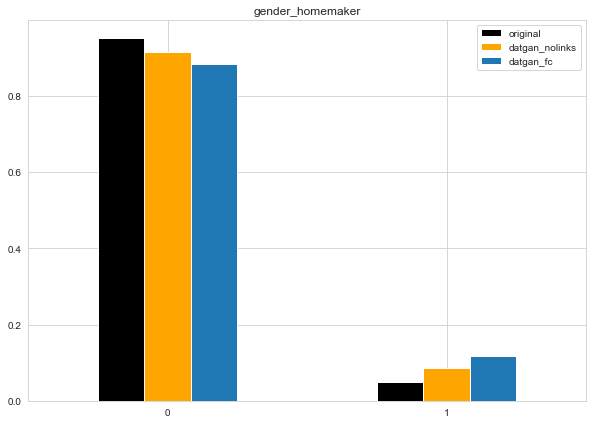

In [29]:
vals = [df[df.work_status == 1].gender for df in dfs]
probs = [v.value_counts(normalize=True) for v in vals]

dct = {}
for l in labels:
    dct[l] = []

idx = np.sort(probs[0].index)

for i in idx:

    for j, l in enumerate(labels):      
        try:
            dct[l].append(probs[j].loc[i])
        except:
            dct[l].append(0)


tmp_df = pd.DataFrame(dct, index=idx)

tmp_df.plot(figsize=(10,7), kind='bar', color=colors)

plt.legend()

plt.xticks(rotation=0)

plt.title('gender_homemaker')

plt.savefig('../figures/tgan-chicago/sub/gender_homemaker.pdf', bbox_inches='tight')
plt.savefig('../figures/tgan-chicago/sub/gender_homemaker.png', bbox_inches='tight')